# Bivariate Analysis

**Purpose:** Analyze relationships between pairs of variables to understand how features relate to each other and to target variables.

**Steps:**
1. Numerical features vs target variables
2. Categorical features vs target variables
3. Feature-to-feature relationships (correlation)

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization settings
sns.set_style('whitegrid')
plt.rcParams['font.size'] = 12
pd.set_option('display.max_columns', None)

## Load Database

In [2]:
# Connect to database and load full dataset
conn = sqlite3.connect('../databases/nhanes_1st.db')
df = pd.read_sql_query('SELECT * FROM raw_dataset', conn)
conn.close()
print(f"Dataset shape: {df.shape}")

Dataset shape: (56893, 29)


In [3]:
# Mental Model:
# for each target:
#     detect target type
#     for each feature:
#         choose correct test based on (feature type, target type)
#         compute ONE strength number
#     rank features

In [4]:
# Step 1: Loop -> computer numbers only
# results = []

# for target in targets:
#     for feature in numerical_features:
#         strength = compute_strength(feature, target)
#         results.append((target, feature, strength))

#     for feature in categorical_features:
#         strength = compute_strength(feature, target)
#         results.append((target, feature, strength))

## STEP 1 — Define your metadata

In [5]:
# Identify variable types: Categorical vs Numerical
print("="*80)
print("VARIABLE TYPE IDENTIFICATION")
print("="*80)

# Define target variables (excluded from feature analysis)
target_columns = [
    'has_cardiovascular_disease',
    'high_waist_circumference', 'high_triglycerides_mg_dl', 'low_hdl_mg_dl', 
    'high_blood_pressure', 'high_glucose_mg_dl',
    'kidney_acr_mg_g', 'liver_alt_U_L'
]

# Get feature columns (exclude targets)
feature_columns = [col for col in df.columns if col not in target_columns]

# Identify numerical vs categorical using pandas
numeric_features = df[feature_columns].select_dtypes(include=[np.number])
numerical_cols = [col for col in numeric_features.columns if df[col].nunique() > 10]
categorical_cols = [col for col in feature_columns if col not in numerical_cols]

# Summary
print(f"\nTotal Features: {len(feature_columns)}")
print(f"  - Numerical (Continuous): {len(numerical_cols)}")
print(f"  - Categorical: {len(categorical_cols)}")
print(f"  - Target Variables: {len(target_columns)}")

print(f"\n📊 Numerical Variables ({len(numerical_cols)}):")
for col in sorted(numerical_cols):
    print(f"  • {col}")

print(f"\n📋 Categorical Variables ({len(categorical_cols)}):")
for col in sorted(categorical_cols):
    print(f"  • {col} ({df[col].nunique()} unique values)")

print(f"\n🎯 Target Variables ({len(target_columns)}):")
for col in sorted(target_columns):
    print(f"  • {col}")







# ---- FEATURES ----
NUM_FEATURES = numerical_cols

CAT_FEATURES = categorical_cols

# ---- TARGETS (FLATTENED) ----
TARGETS = {
    'cardio': {
        'type': 'binary',
        'columns': ['has_cardiovascular_disease']
    },
    'metabolic': {
        'type': 'binary',
        'columns': [
            'high_waist_circumference',
            'high_triglycerides_mg_dl',
            'low_hdl_mg_dl',
            'high_blood_pressure',
            'high_glucose_mg_dl'
        ]
    },
    'kidney': {
        'type': 'regression',
        'columns': ['kidney_acr_mg_g']
    },
    'liver': {
        'type': 'regression',
        'columns': ['liver_alt_U_L']
    }
}

VARIABLE TYPE IDENTIFICATION

Total Features: 21
  - Numerical (Continuous): 18
  - Categorical: 3
  - Target Variables: 8

📊 Numerical Variables (18):
  • age
  • alcohol_drinks_per_week
  • bilirubin_mg_dl
  • body_mass_index
  • cholesterol_mg_dl
  • creatinine_mg_dl
  • heart_rate_bpm
  • height_cm
  • hemoglobin_g_dl
  • income_ratio
  • liver_ast_U_L
  • liver_ggt_U_L
  • mean_corpuscular_volume_fL
  • platelets_count
  • potassium_mmol_L
  • sodium_mmol_L
  • uric_acid_mg_dl
  • white_blood_cells_count

📋 Categorical Variables (3):
  • ethnicity (6 unique values)
  • gender (2 unique values)
  • smoking_status (3 unique values)

🎯 Target Variables (8):
  • has_cardiovascular_disease
  • high_blood_pressure
  • high_glucose_mg_dl
  • high_triglycerides_mg_dl
  • high_waist_circumference
  • kidney_acr_mg_g
  • liver_alt_U_L
  • low_hdl_mg_dl


## STEP 2 — Write ONE function: compute_strength

In [6]:
def compute_strength(df, feature, target, feature_type, target_type):
    """
    Returns a single numeric strength score.
    """
    # Drop missing
    sub = df[[feature, target]].dropna()
    if sub.empty:
        return 0.0

    # ---- Numerical feature ----
    if feature_type == 'numerical':

        if target_type in ['binary', 'regression']:
            # correlation works for:
            # - numerical vs numerical
            # - numerical vs binary
            return sub[feature].corr(sub[target])

    # ---- Categorical feature ----
    elif feature_type == 'categorical':

        if target_type == 'binary':
            # difference between max and min positive rate
            rates = (
                sub.groupby(feature)[target]
                .mean()
            )
            return rates.max() - rates.min()

        if target_type == 'regression':
            means = (
                sub.groupby(feature)[target]
                .mean()
            )
            return means.var()

    return 0.0

## STEP 3 — Loop over targets × features

In [7]:
results = []

for group_name, info in TARGETS.items():
    target_type = info['type']

    for target_col in info['columns']:

        # Numerical features
        for feature in NUM_FEATURES:
            strength = compute_strength(
                df,
                feature,
                target_col,
                feature_type='numerical',
                target_type=target_type
            )

            results.append({
                'target_group': group_name,
                'target': target_col,
                'feature': feature,
                'feature_type': 'numerical',
                'strength': strength
            })

        # Categorical features
        for feature in CAT_FEATURES:
            strength = compute_strength(
                df,
                feature,
                target_col,
                feature_type='categorical',
                target_type=target_type
            )

            results.append({
                'target_group': group_name,
                'target': target_col,
                'feature': feature,
                'feature_type': 'categorical',
                'strength': strength
            })


## STEP 4 — Rank features (THIS IS THE PAYOFF)

In [8]:
results_df = pd.DataFrame(results)

results_df['abs_strength'] = results_df['strength'].abs()

ranked = (
    results_df
    .sort_values(['target', 'abs_strength'], ascending=[True, False])
)

In [9]:
ranked[ranked['target'] == 'has_cardiovascular_disease'].head(5)

,target_group,target,feature,feature_type,strength,abs_strength
0,cardio,has_cardiovascular_disease,age,numerical,0.322301,0.322301
9,cardio,has_cardiovascular_disease,creatinine_mg_dl,numerical,0.158126,0.158126
16,cardio,has_cardiovascular_disease,cholesterol_mg_dl,numerical,-0.136795,0.136795
13,cardio,has_cardiovascular_disease,uric_acid_mg_dl,numerical,0.110813,0.110813
15,cardio,has_cardiovascular_disease,potassium_mmol_L,numerical,0.105407,0.105407


## STEP 5 — MINIMAL plotting

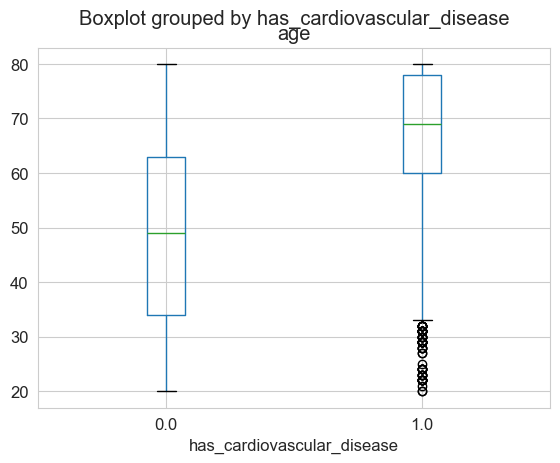

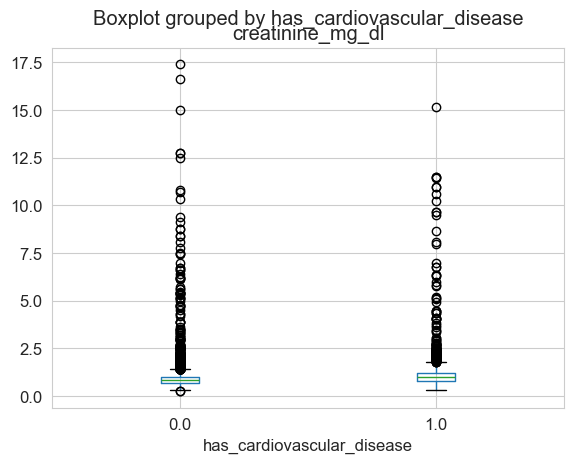

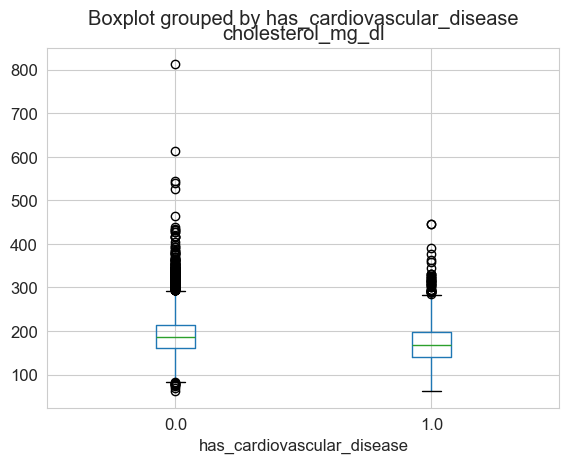

In [10]:
top_features = (
    ranked[ranked['target'] == 'has_cardiovascular_disease']
    .head(3)
)

for _, row in top_features.iterrows():
    f = row['feature']

    if row['feature_type'] == 'numerical':
        df.boxplot(column=f, by='has_cardiovascular_disease')

    else:
        df.groupby(f)['has_cardiovascular_disease'].mean().plot(kind='bar')


In [11]:
# # =========================================================
# # 1. NUMERICAL FEATURES VS TARGET VARIABLES
# # =========================================================

# print("="*80)
# print("1. NUMERICAL FEATURES VS TARGET VARIABLES")
# print("="*80)

# # Key numerical features to compare with CVD
# key_features = ['age', 'body_mass_index', 'cholesterol_mg_dl', 'heart_rate_bpm', 
#                 'creatinine_mg_dl', 'hemoglobin_g_dl']

# print(f"\nComparing {len(key_features)} key features with Cardiovascular Disease:")

# # Boxplots: Numerical features vs CVD status
# n_cols = 3
# n_rows = int(np.ceil(len(key_features) / n_cols))
# plt.figure(figsize=(15, n_rows * 4))

# for i, col in enumerate(key_features):
#     plt.subplot(n_rows, n_cols, i + 1)
#     sns.boxplot(x='has_cardiovascular_disease', y=col, data=df, 
#                 palette='viridis', hue='has_cardiovascular_disease', legend=False)
#     plt.title(f'{col} vs CVD Status', fontsize=12)
#     plt.xlabel('CVD Status')
#     plt.ylabel(col)
#     plt.xticks([0, 1], ['No CVD', 'Has CVD'])

# plt.suptitle('Numerical Features Distribution by CVD Status', fontsize=16, y=1.02)
# plt.tight_layout()
# plt.show()

In [12]:
# # =========================================================
# # 2. CATEGORICAL FEATURES VS TARGET VARIABLES
# # =========================================================

# print("\n" + "="*80)
# print("2. CATEGORICAL FEATURES VS TARGET VARIABLES")
# print("="*80)

# # Analyze categorical features impact on CVD
# categorical_features = ['gender', 'ethnicity', 'smoking_status']

# for cat_feature in categorical_features:
#     if cat_feature in df.columns:
#         print(f"\n{cat_feature.upper()} vs Cardiovascular Disease:")
        
#         # Calculate CVD rate by category
#         cvd_by_category = df.groupby(cat_feature)['has_cardiovascular_disease'].agg(['mean', 'count'])
#         cvd_by_category['cvd_rate'] = cvd_by_category['mean'] * 100
#         cvd_by_category = cvd_by_category.sort_values('cvd_rate', ascending=False)
        
#         print(cvd_by_category[['cvd_rate', 'count']].to_string())
        
#         # Visualize
#         plt.figure(figsize=(8, 5))
#         sns.barplot(x=cvd_by_category.index, y=cvd_by_category['cvd_rate'], 
#                    palette='magma', hue=cvd_by_category.index, legend=False)
#         plt.title(f'CVD Incidence Rate by {cat_feature.title()}', fontsize=14)
#         plt.ylabel('CVD Rate (%)')
#         plt.xlabel(cat_feature.title())
#         plt.xticks(rotation=45, ha='right')
#         plt.tight_layout()
#         plt.show()

In [13]:
# # =========================================================
# # 3. FEATURE-TO-FEATURE RELATIONSHIPS (CORRELATION)
# # =========================================================

# print("\n" + "="*80)
# print("3. FEATURE CORRELATION ANALYSIS")
# print("="*80)

# # Select key numerical features for correlation analysis
# corr_features = [
#     'age', 'body_mass_index', 'cholesterol_mg_dl', 'heart_rate_bpm', 
#     'hemoglobin_g_dl', 'creatinine_mg_dl', 'income_ratio', 'has_cardiovascular_disease'
# ]

# print(f"\nCorrelation matrix for {len(corr_features)} key features:")

# # Correlation heatmap
# plt.figure(figsize=(10, 8))
# corr_matrix = df[corr_features].corr()
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", 
#            linewidths=0.5, square=True, center=0, vmin=-1, vmax=1)
# plt.title('Correlation Matrix: Key Features vs CVD', fontsize=14)
# plt.tight_layout()
# plt.show()

# # Find top correlations with CVD
# print("\nTop correlations with Cardiovascular Disease:")
# cvd_corr = corr_matrix['has_cardiovascular_disease'].abs().sort_values(ascending=False)
# cvd_corr = cvd_corr[cvd_corr.index != 'has_cardiovascular_disease']  # Remove self
# print(cvd_corr.head(10).to_string())
